In [1]:
import rebound
%matplotlib inline
import matplotlib.pyplot as plt
import observations
import state
import mcmc
import numpy as np
import corner
from ipywidgets import FloatProgress
from IPython.display import display

/Users/rein/git/rebound/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Setting up fake observations

In [2]:
true_state = state.State(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0.0, "l":0.}])
obs = observations.FakeObservation(true_state, Npoints=100, error=1e-4, tmax=10.)

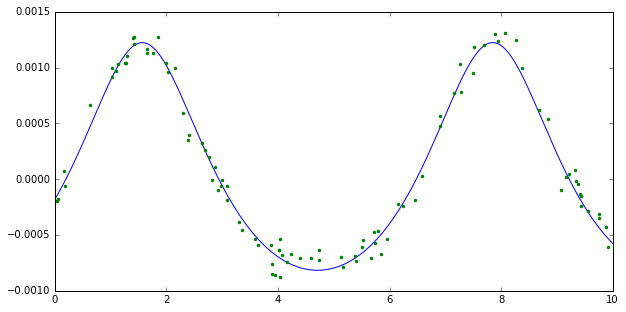

In [3]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(*true_state.get_rv_plotting(tmax=10.))
ax.plot(obs.t, obs.rv, ".")

# Ensemble

In [8]:
Nwalkers = 10
ens = mcmc.Ensemble(true_state,obs,scales={"m":1e-3, "a":1., "h":0.5, "k":0.5, "l":np.pi},nwalkers=Nwalkers)
Niter = 10000
chain = np.zeros((Niter,ens.state.Nvars))
chainlogp = np.zeros(Niter)
f = FloatProgress(min=0, max=Niter/Nwalkers)
display(f)
for i in range(Niter/Nwalkers):
    ens.step_force()
    for j in range(Nwalkers):
        chain[j*Niter/Nwalkers+i] = ens.states[j]
        chainlogp[j*Niter/Nwalkers+i] = ens.lnprob[j]
    f.value = i

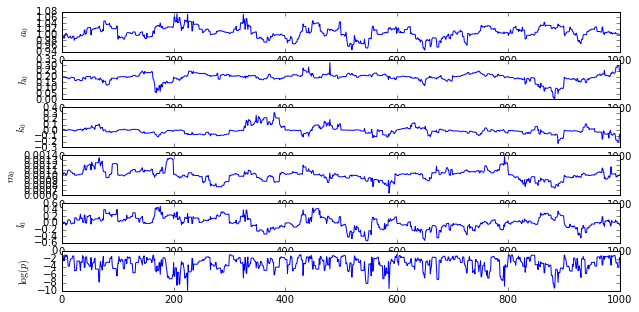

In [5]:
fig = plt.figure(figsize=(10,5))
for i in range(ens.state.Nvars):
    ax = plt.subplot(ens.state.Nvars+1,1,1+i)
    ax.set_ylabel(ens.state.get_keys()[i])
    ax.plot(chain[:,i])
ax = plt.subplot(ens.state.Nvars+1,1,ens.state.Nvars+1)
ax.set_ylabel("$\log(p)$")
ax.plot(chainlogp)    

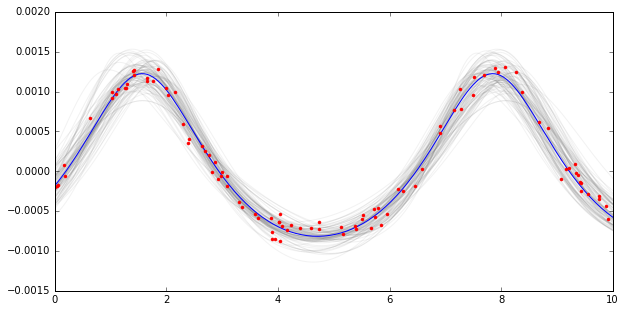

In [6]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
for c in np.random.choice(Niter,100):
    s = ens.state.deepcopy()
    s.set_params(chain[c])
    ax.plot(*s.get_rv_plotting(tmax=10.), alpha=0.1, color="gray")
ax.plot(*true_state.get_rv_plotting(tmax=10.), color="blue")
ax.plot(obs.t, obs.rv, "r.")    

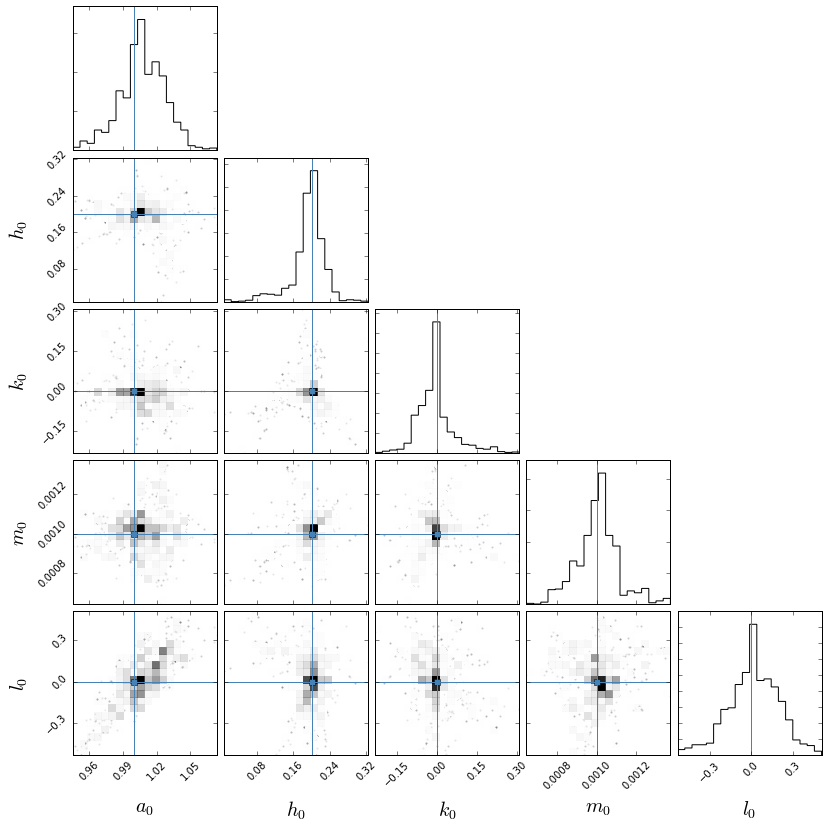

In [7]:
figure = corner.corner(chain, labels=s.get_keys(), plot_contours=False, truths=true_state.get_params(),label_kwargs={"fontsize":20})

# SMALA 
Starting from exact solution.

In [35]:
smala = mcmc.Smala(true_state,obs)
Niter = 1000
chain = np.zeros((Niter,smala.state.Nvars))
chainlogp = np.zeros(Niter)
tries = 0
f = FloatProgress(min=0, max=Niter)
display(f)
for i in range(Niter):
    tries += smala.step_force()
    chain[i] = smala.state.get_params()
    chainlogp[i] = smala.state.logp
    f.value = i
print("Acceptance rate: %.2f%%"%(float(Niter)/tries*100))

Acceptance rate: 79.37%


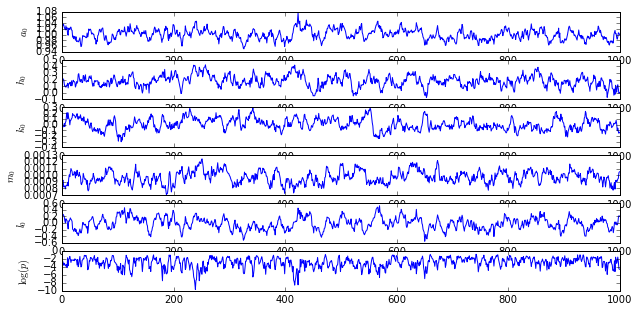

In [36]:
fig = plt.figure(figsize=(10,5))
for i in range(smala.state.Nvars):
    ax = plt.subplot(smala.state.Nvars+1,1,1+i)
    ax.set_ylabel(smala.state.get_keys()[i])
    ax.plot(chain[:,i])
ax = plt.subplot(smala.state.Nvars+1,1,smala.state.Nvars+1)
ax.set_ylabel("$\log(p)$")
ax.plot(chainlogp)    

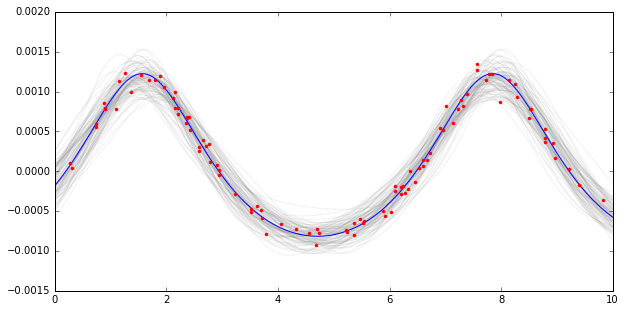

In [37]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
for c in np.random.choice(Niter,100):
    s = smala.state.deepcopy()
    s.set_params(chain[c])
    ax.plot(*s.get_rv_plotting(tmax=10.), alpha=0.1, color="gray")
ax.plot(*true_state.get_rv_plotting(tmax=10.), color="blue")
ax.plot(obs.t, obs.rv, "r.")    

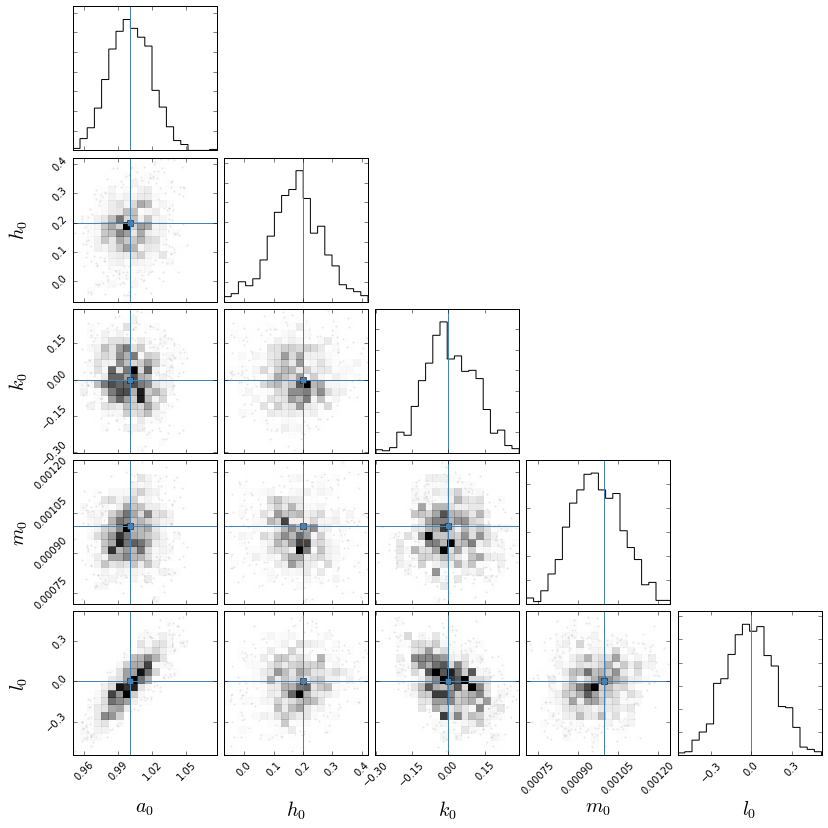

In [38]:
figure = corner.corner(chain, labels=s.get_keys(), plot_contours=False, truths=true_state.get_params(),label_kwargs={"fontsize":20})

# Metropolis Hastings
Starting from a very true initial set of parameters.

In [39]:
mh = mcmc.Mh(true_state,obs)
mh.set_scales({"m":1e-3, "a":1., "h":0.5, "k":0.5, "l":np.pi})
mh.step_size = 4e-2
Niter = 1000
chain = np.zeros((Niter,mh.state.Nvars))
chainlogp = np.zeros(Niter)
tries = 0
f = FloatProgress(min=0, max=Niter)
display(f)
for i in range(Niter):
    tries += mh.step_force()
    chain[i] = mh.state.get_params()
    chainlogp[i] = mh.state.logp
    f.value = i
print("Acceptance rate: %.2f%%"%(float(Niter)/tries*100))

Acceptance rate: 23.68%


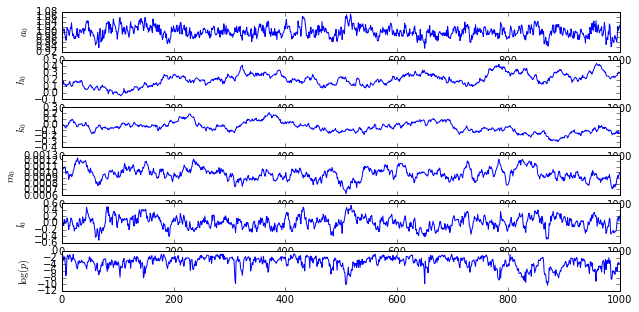

In [40]:
fig = plt.figure(figsize=(10,5))
for i in range(s.Nvars):
    ax = plt.subplot(s.Nvars+1,1,1+i)
    ax.set_ylabel(s.get_keys()[i])
    ax.plot(chain[:,i])    
ax = plt.subplot(s.Nvars+1,1,s.Nvars+1)
ax.set_ylabel("$\log(p)$")
ax.plot(chainlogp)    

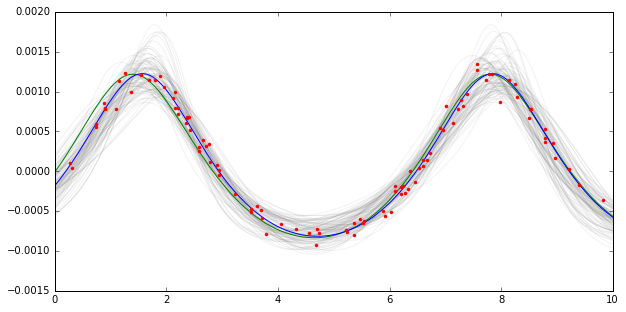

In [41]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
for c in np.random.choice(Niter,100):
    s = mh.state.deepcopy()
    s.set_params(chain[c])
    ax.plot(*s.get_rv_plotting(tmax=10.), alpha=0.1, color="gray")
s = mh.state.deepcopy()
s.set_params(chain[0])
ax.plot(*s.get_rv_plotting(tmax=10.), color="green")
ax.plot(*true_state.get_rv_plotting(tmax=10.), color="blue")
ax.plot(obs.t, obs.rv, "r.")    

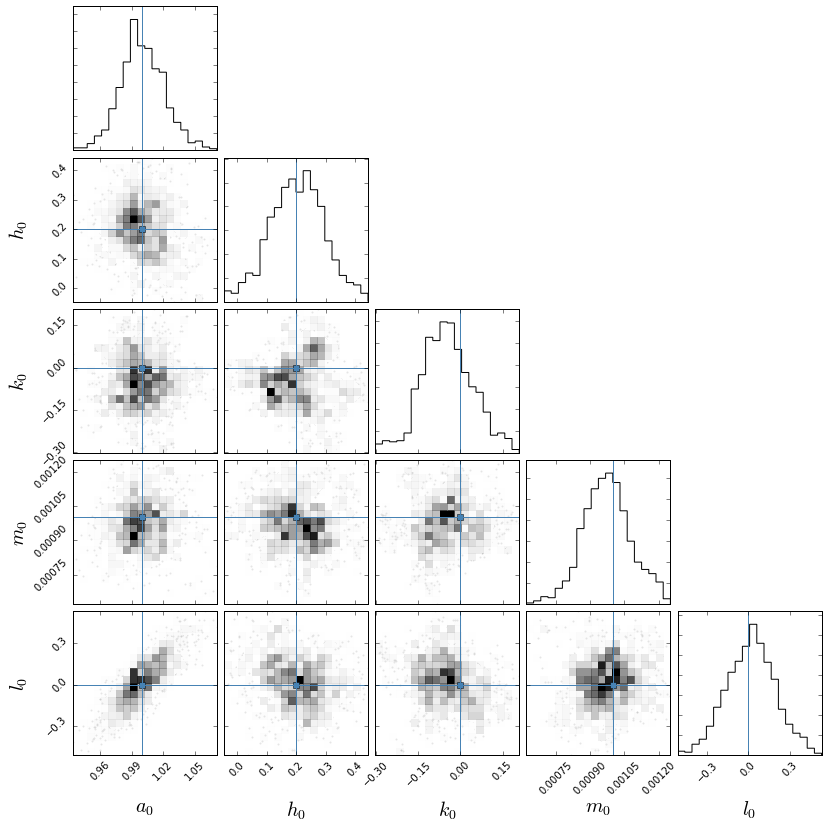

In [42]:
figure = corner.corner(chain, labels=s.get_keys(), plot_contours=False, truths=true_state.get_params(),label_kwargs={"fontsize":20})